In [1]:
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Embedding, Masking, Lambda, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pathlib import Path
import os
import itertools
from importnb import Notebook
with Notebook(): 
    import Utilities

In [2]:
# Specify the path to OneDrive
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")

In [3]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [4]:
# Load data 
news_path = ONEDRIVE_PATH / "Input Data/financial_headlines_20061020-20131119.pkl"
data = pd.DataFrame(pd.read_pickle(news_path))
data.set_index('date',inplace=True)

In [6]:
path = ONEDRIVE_PATH / "Input Data/all_reuters_news_embedded_bert_base_nli_mean.npy"
if os.path.exists(path):
    x = np.load(path)
    embed_dim = x.shape[-1]
    max_nbr_titles = x.shape[-2]
    print("Loaded previously saved embeddings.")
else:
    texts = []
    for i,date in enumerate(data.index.drop_duplicates()): 
        if i % 100: 
            print("{} % ...".format(round(100 * i / len(data.index.drop_duplicates()),3)),end='\r')
        temp_titles = []
        for title in data.loc[date].values:
            temp_titles.append(title[0])
        texts.append(sbert_model.encode(temp_titles))
    print("100 % ...")
    max_nbr_titles = max([len(text) for text in texts])
    embed_dim = texts[0][0].shape[0]
    x = np.zeros((n,max_nbr_titles,embed_dim))
    # Include embeddings in matrix and pad with (tensors) of zeros. 
    for i,titles in enumerate(texts): 
        for j,title in enumerate(titles): 
            x[i,j] = title
    np.save(path,x)

Loaded previously saved embeddings.


In [110]:
config = {
    'embed_dim': embed_dim,    # Dimensions to use for the word embedding
    'max_len': max_nbr_titles,
    'lookback': 1,        # How far back to collect data in the recurrent layer (days)
    'delay': 1,           # How far ahead to predict data (days)
    'p': 1,               # Order of the AR-part of the model
    'd': 1,               # Integrated order
    'q': 1,               # Included moving average terms 
    'train_part' : 0.8,   # Part of data to be used for training
    'val_part' : 0.1,     # Part of data to be used for validation
    'test_part' : 0.1,    # Part of data to be used for testing
    'series': '1 YEAR',   # What series we currently want to predict, '1 YEAR', '3 YEAR' or 'S&P'
    'start_date': '2006-10-20',
    'end_date': '2013-11-19',
}

In [111]:
y = Utilities.load_direction_labels(config)

# Remove last row of the x-matrix, since there's no label for that entry
if x.shape[0] != len(y): 
    x = x[:-1]

In [112]:
(x_train, y_train), (x_test, y_test) = Utilities.shuffle_and_partition(x,y,test_part = config['test_part'])
print("Shape of x_train:",x_train.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of y_test:",y_test.shape)

Shape of x_train: (2322, 104, 768)
Shape of y_train: (2322,)
Shape of x_test: (259, 104, 768)
Shape of y_test: (259,)


In [113]:
# Create functions for custom 'MergeEmedding'-layer which averages 
# the embeddings over all words after the embedding layer 

def merge_embeddings(x):
    # Sum the embeddings for every word slot. If this is zero, there is no word in this slot
    non_zero = K.sum(K.cast(K.not_equal(K.sum(x,axis=2),0),tf.float32))
    return K.sum(x,axis=1) / non_zero


def merge_output_shape(input_shape):
    return (input_shape[0], input_shape[2])

In [114]:
def create_nn(n_nodes, lr=0.001):
    # n_nodes is a list with the number of nodes per layer, starting from the input 
    model = Sequential()
    model.add(Lambda(merge_embeddings, merge_output_shape, input_shape=x_train.shape[1:]))
    for n in n_nodes:
        model.add(Dense(n,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    rms = optimizers.RMSprop(learning_rate=lr)
    model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
    return model

def train_and_format(model,x,y,bs,epochs, results, layers, nodes,lr,verbose):
    name = f"{bs}_{layers}_{nodes}"
    temp_history = model.fit(x, y, batch_size=bs, validation_split=0.2, epochs = epochs,verbose=verbose)
    return results.append(pd.Series([np.mean(temp_history.history['val_acc'][-5:]),
                                     temp_history,model,
                                     layers,nodes,
                                     bs, lr],name=name,
                                    index=['Mean Val Acc','History','Model','Layers','Nodes','Batch Size','Learning Rate']))

def continue_training(results_row,x_train,y_train, epochs, validation_split=0.2, verbose=0): 
    temp_history = results_row['Model'].fit(x_train, y_train, validation_split=validation_split, epochs=epochs, verbose=verbose)
    [results_row['History'].history['loss'].append(val) for val in temp_history.history['loss']]
    [results_row['History'].history['val_loss'].append(val) for val in temp_history.history['val_loss']]
    [results_row['History'].history['acc'].append(val) for val in temp_history.history['acc']]
    [results_row['History'].history['val_acc'].append(val) for val in temp_history.history['val_acc']]
    
    
    

In [117]:
n_layers = [2,3]
n_nodes = [25, 50, 100, 300, 500]
learning_rates = [0.0001]
batch_sizes = [12,36]
verbose = 0
epochs = 30
results = pd.DataFrame(columns=['Mean Val Acc','History','Model', 'Layers', 'Nodes','Batch Size','Learning Rate'])
n_configs = sum([len(n_nodes)**l for l in n_layers]) * len(batch_sizes) * len(learning_rates)
ctr = 0
print('Testing {} combinations. '.format(n_configs))
for layers in n_layers:
    if layers == 1: node_configs = list(itertools.product(n_nodes))
    elif layers == 2: node_configs = list(itertools.product(n_nodes, n_nodes))
    elif layers == 3: node_configs = list(itertools.product(n_nodes, n_nodes, n_nodes))
    elif layers == 4: node_configs = list(itertools.product(n_nodes, n_nodes, n_nodes, n_nodes))
    for bs in batch_sizes: 
        for temp_nodes in node_configs:
            for lr in learning_rates: 
                ctr += 1 
                model = create_nn(temp_nodes, lr)
                results = train_and_format(model, x_train, y_train, bs, epochs, results, layers, temp_nodes, lr,verbose=verbose)
                print("{} %     ".format(round(100 * ctr / n_configs,2)),end='\r')
            
            

Testing 300 combinations. 


In [118]:
k = 3
print("Top {} configs: ".format(k))
k_best = np.argpartition(results['Mean Val Acc'],-k)[-k:]
results.iloc[k_best]

Top 3 configs: 


,Mean Val Acc,History,Model,Layers,Nodes,Batch Size,Learning Rate
"12_3_(100, 25, 300)",0.705806,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,3,"(100, 25, 300)",12,0.0001
"12_3_(50, 500, 25)",0.705806,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,3,"(50, 500, 25)",12,0.0001
"12_3_(50, 500, 50)",0.705806,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,3,"(50, 500, 50)",12,0.0001


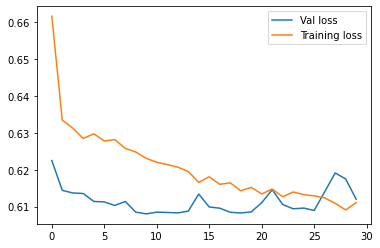

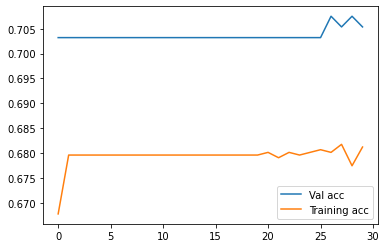

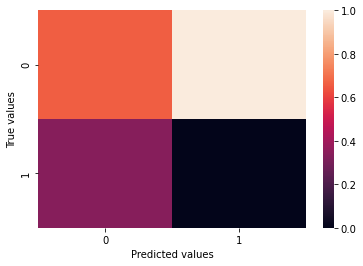

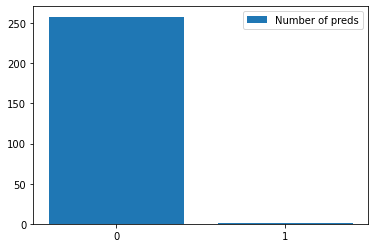

              precision    recall  f1-score   support

         0.0       0.66      0.99      0.80       172
         1.0       0.00      0.00      0.00        87

    accuracy                           0.66       259
   macro avg       0.33      0.50      0.40       259
weighted avg       0.44      0.66      0.53       259

12_3_(100, 25, 300)


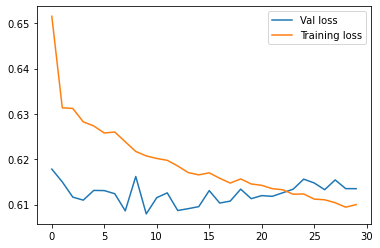

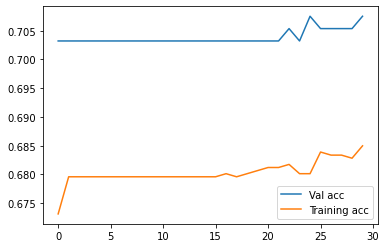

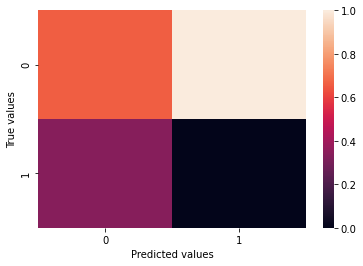

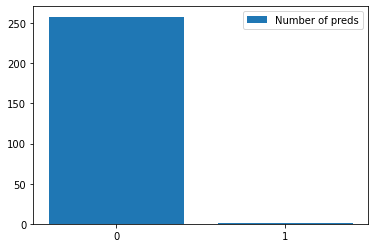

              precision    recall  f1-score   support

         0.0       0.66      0.99      0.80       172
         1.0       0.00      0.00      0.00        87

    accuracy                           0.66       259
   macro avg       0.33      0.50      0.40       259
weighted avg       0.44      0.66      0.53       259

12_3_(50, 500, 25)


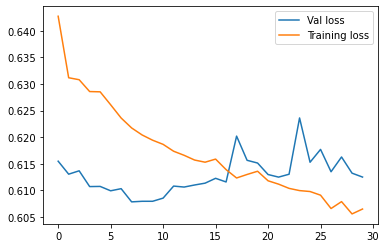

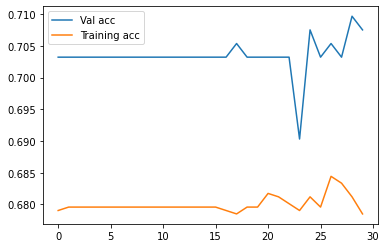

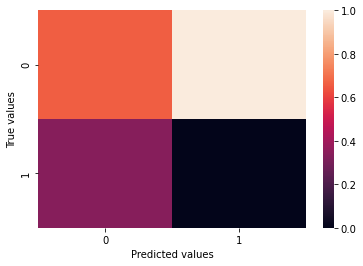

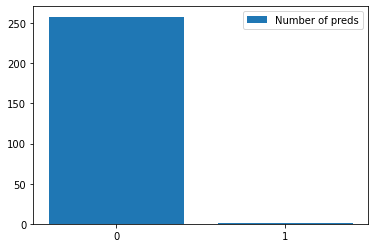

              precision    recall  f1-score   support

         0.0       0.66      0.99      0.80       172
         1.0       0.00      0.00      0.00        87

    accuracy                           0.66       259
   macro avg       0.33      0.50      0.40       259
weighted avg       0.44      0.66      0.53       259

12_3_(50, 500, 50)


In [119]:
for i in k_best: 
    plt.plot(results.iloc[i]['History'].history['val_loss'],label='Val loss')
    plt.plot(results.iloc[i]['History'].history['loss'],label='Training loss')
    plt.legend()
    plt.show()
    plt.plot(results.iloc[i]['History'].history['val_acc'],label='Val acc')
    plt.plot(results.iloc[i]['History'].history['acc'],label='Training acc')
    plt.legend()
    plt.show()
    model = results.iloc[i]['Model']
    model.evaluate(x_test,y_test,verbose=0)
    y_test_pred = np.round(model.predict(x_test))
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    plt.show()
    y_sums = np.zeros(2)
    y_sums[0] = sum(y_test_pred == 0)
    y_sums[1] = sum(y_test_pred == 1)
    plt.bar([0,1],y_sums,label='Number of preds')
    plt.xticks([0,1])
    plt.legend()
    plt.show()
    print(classification_report(y_test, y_test_pred))
    print(results.index[i])


In [69]:
for k in k_best:
    continue_training(results.iloc[k],x_train, y_train, epochs=50,verbose=1)

In [122]:
print("PREDICTION: ")
print("0:",sum(y_test_pred == 0)[0])
print("1:",sum(y_test_pred == 1)[0])
print("ACTUAL VALUES: ")
print("0:",sum(y_test == 0))
print("1:",sum(y_test == 1))

PREDICTION: 
0: 258
1: 1
ACTUAL VALUES: 
0: 172
1: 87


In [13]:
test_sents = [
    "Veberöd Mushroom Factory claims quality award."
    "The economy is dead.",
    "The American President has committed suicide.", 
    "Worst crisis in 1000 years. ",
    "Corona virus stopps all production in 100 countries.",
    "BEST DAY EVER!",
    "Amazing comeback from american stocks",
    "Truly awesome day on the market today."
]
enc_sents = sbert_model.encode(test_sents)
x_inp = np.zeros((1, config['max_len'], config['embed_dim'])) 
for i,row in enumerate(enc_sents):
    x_inp[0,i] = row


In [14]:
y_pred = model.predict(x_inp)

In [15]:
y_pred

array([[0.31967512]], dtype=float32)

In [76]:
reg = Utilities.load_regression_labels(config)

Loaded previously constructed labels. 


In [78]:
np.argmin(reg)

691

In [85]:
data.index.drop_duplicates()[692]

Timestamp('2008-09-13 00:00:00')

In [88]:
[print(val) for val in data['2008-09-12':'2008-09-14']['title']]

Cisco to outline long-term growth strategy next week
Health Net to pay $3.6 million in fine: report
J&J Vice Chairman Poon to retire in March
JPMorgan not in talks to buy WaMu: report
AIG could hold investor call as soon as Monday: source
Alitalia unions get extra day to salvage bid
Italian investors say Alitalia talks can't go on
Alitalia to start layoff process Friday: union
Alitalia receives offers for maintenance, cargo
Pope prays for Alitalia as 3rd rescue bid falters
TIMELINE: Alitalia's troubled sale process
Amazon.com hires Microsoft exec: NY Post
Wagoner tells Congress: "not seeking bailouts"
GM CEO says automakers not seeking bailout
Bank of America likely to win Lehman: analyst Bove
Mexico's Cemex shares plunge on outlook cut
Chrysler sees U.S. auto market gains toward end 2009
GM to provide $10.6 billion to support Delphi
Deutsche Bank to swoop on $13 billion Postbank
Fidelity settles N.Y. and Mass. auction rate probes
TIMELINE: Recent German bank sector mergers
Lehman-owne

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]